# Optimize the Autoregressive RNN with continuous input
- This model is autoregressive, which means that the prediction of the last time step is the input of the current time step. This way the model can predict a varying number of steps into the future without retraining
- Some features, like time and weather, are fed into the model from outside even during prediction phase so the model does not have to predict those by itself

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

sns.set_theme()

### Import data

In [2]:
# df = pd.read_pickle("..\data\data_prepared.pkl")
el = pd.read_pickle("..\data\prepared\electricity+time_2017-2021.pkl")
el.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2017-01-01 00:00:00+00:00,15498.0,0.0,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0


In [3]:
# Features that will be extracted from the weather data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    "precipitation_height": "precip",
    "sunshine_duration": "sun"
}

# Concatenate all weather parameters into one data frame
wx_list = []
for name, handle in wx_params.items():
    wx_list.append(pd.read_pickle("../data/weather/cleaned/"+name+".pkl").add_prefix(handle+"_"))

wx = pd.concat(wx_list, axis=1, ignore_index=False, verify_integrity=True)
wx.head()


,temp_00183,temp_00701,temp_00856,temp_00953,temp_00963,temp_01443,temp_01605,temp_01694,temp_03032,temp_03231,...,sun_00856,sun_00953,sun_00963,sun_01443,sun_01605,sun_01694,sun_03032,sun_03231,sun_04104,sun_04177
2017-01-01 00:00:00+00:00,277.45,276.95,269.15,266.15,275.95,268.65,276.75,275.95,280.85,268.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00+00:00,277.65,277.05,268.85,265.45,276.15,268.25,276.45,276.15,280.95,267.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00+00:00,277.85,277.15,269.95,266.95,275.65,268.65,275.95,276.25,281.05,267.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00+00:00,277.85,277.25,269.25,266.35,274.55,268.55,276.45,276.35,281.05,266.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00+00:00,277.95,277.25,268.85,266.35,275.15,268.05,276.75,276.55,280.75,266.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [4]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

df = pd.concat([el, wx], axis=1, ignore_index=False, verify_integrity=True)

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

scaler = MinMaxScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

len(df_train.columns)

68

### Normalize the data

### Data Windowing
#### 1. Indexes and offsets

- Windows Generator that can create multiple inputs, one for the inputs that are only known in the past (power production) and one for inputs that are also known in the future (time and weather)

In [5]:
class WindowGenerator():
    def __init__(self, past_width, future_width,
                 label_columns, precise_columns=None, forecast_columns=None,
                 train_df=df_train, val_df=df_val, test_df=df_test):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Check if length of provided features match with data frame
        num_columns = 0
        num_columns += len(label_columns)
        if precise_columns is not None:
            num_columns += len(precise_columns)
        if forecast_columns is not None:
            num_columns += len(forecast_columns)
        assert num_columns == len(train_df.columns), \
            "Length of provided label, precise, and forecast features do not match data frame"

        # Work out the column indices
        self.columns_indices = {name: i for i, name in
                                enumerate(train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
        self.precise_columns = precise_columns
        self.forecast_columns = forecast_columns

        # Work out the window parameters.
        self.past_width = past_width
        self.future_width = future_width

        self.total_window_size = past_width + future_width

        self.input_past_slice = slice(0, past_width)
        self.input_past_indices = np.arange(self.total_window_size)[
            self.input_past_slice]

        self.input_future_slice = slice(self.past_width, -1)
        self.input_future_indices = np.arange(self.total_window_size)[
            self.input_future_slice]

        self.label_slice = slice(self.past_width, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.label_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size:    {self.total_window_size}',
            f'Input past indices:   {self.input_past_indices}',
            f'Input future indices: {self.input_future_indices}',
            f'Label indices:        {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        # f'Precise column name(s):  {self.precise_columns}',
        # f'Forecast column name(s): {self.forecast_columns}'])


#### 2. Split

In [6]:
def split_window(self, features):
    # Past: All inputs are known
    inputs_past = features[:, self.input_past_slice, :]

    # Future: Only precise and forecast inputs are known
    if self.precise_columns is None:
        self.precise_columns = []
    if self.forecast_columns is None:
        self.forecast_columns = []
    self.input_future_columns = self.precise_columns + self.forecast_columns

    inputs_future = tf.stack(
        [features[:, self.input_future_slice, self.columns_indices[name]]
            for name in self.input_future_columns],
        axis=-1)

    labels = tf.stack(
        [features[:, self.label_slice, self.columns_indices[name]]
            for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs_past.set_shape([None, self.past_width, None])
    inputs_future.set_shape([None, self.future_width-1, None])
    labels.set_shape([None, self.future_width, None])

    # Return inputs and labels
    # The past and future input tuple will be unpacked in the model.call() method
    return (inputs_past, inputs_future), labels


WindowGenerator.split_window = split_window


#### 3. Plot

In [7]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    (inputs_past, inputs_future) = inputs
    plt.figure(figsize=(12, 8))
    plot_col_index = self.columns_indices[plot_col]
    max_n = min(max_subplots, len(inputs_past))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)

        # Plot past inputs
        plt.plot(self.input_past_indices, inputs_past[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        label_col_index = self.label_columns_indices.get(plot_col, None)

        # Add last point of past array to future arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_past_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs_past[n, :, plot_col_index][-1])

        # Plot labels
        plt.plot(label_indices_plot, labels_plot,
                 'C2', label='Labels', marker='.', zorder=1)

        # Plot prediction
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs_past[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        # x Ticks every 6 hours
        plt.xticks(np.arange(self.input_past_indices[0], self.label_indices[-1]+2, 6))

        plt.ylabel(f'{plot_col} [normed]')
        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot


#### 4. Create `tf.data.Datasets`

In [8]:
def make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


In [9]:
@property
def train(self):
    self._train = self.make_dataset(self.train_df)
    return self._train

# @train.setter
# def train(self, value):
#     self._train = value


@property
def val(self):
    self._val = self.make_dataset(self.val_df)
    return self._val

# @val.setter
# def val(self, value):
#     self._val = value


@property
def test(self):
    self._test = self.make_dataset(self.test_df)
    return self._test

# Setting of test property not allowed


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.test` dataset
        result = next(iter(self.test))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


## Window creation

In [10]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = list(wx.columns)

PAST_STEPS = 24
PREDICTION_STEPS = 12

window = WindowGenerator(
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features
)

window


Total window size:    36
Input past indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Input future indices: [24 25 26 27 28 29 30 31 32 33 34]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['prod_wind', 'prod_solar']

Now, the `WindowGenerator` object gives access to the tf.data.Dataset objects, to easily iterate over the data.

The `Dataset.element_spec` property tells the structure, data types, and shapes of the dataset elements.

In [11]:
window.train.element_spec

((TensorSpec(shape=(None, 24, 68), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 11, 66), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 12, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [12]:
for (example_inputs_past, example_inputs_future), example_labels in window.train.take(1):
  print(f'Inputs past shape (batch, time, features): {example_inputs_past.shape}')
  print(f'Inputs fut. shape (batch, time, features): {example_inputs_future.shape}')
  print(f'Labels shape      (batch, time, features): {example_labels.shape}')

Inputs past shape (batch, time, features): (32, 24, 68)
Inputs fut. shape (batch, time, features): (32, 11, 66)
Labels shape      (batch, time, features): (32, 12, 2)


Plot an example window:

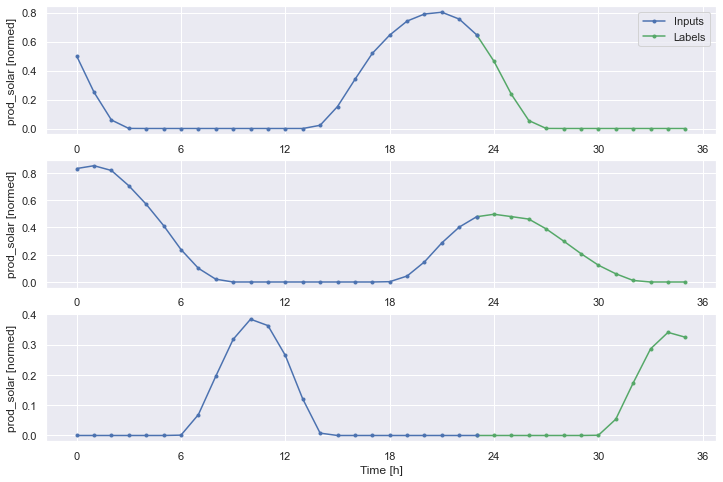

In [13]:
window.plot(plot_col="prod_solar")
# multi_window.plot(plot_col="prod_wind")

## Autoregressive LSTM
The model predicts individual time steps that are fed back into itself, so that the model can produce output with a varying length.
This is implemented in the custom model class `AutoRegressiveRNN`.

In [14]:
class AutoRegressiveRNN(tf.keras.Model):
    def __init__(self, units: list, out_steps: int, rnn_type="LSTM"):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.type = rnn_type
        self.rnn_cells = []
        self.rnn_layers = []
        match rnn_type:
            case "LSTM":
                for unit in self.units:
                    self.rnn_cells.append(tf.keras.layers.LSTMCell(unit))
            case "GRU":
                for unit in self.units:
                    self.rnn_cells.append(tf.keras.layers.GRUCell(unit))
            case other:
                raise AssertionError("Unknown type")
        # Wrap the cells in an RNN to simplify the `warmup` method.
        for i, rnn_cell in enumerate(self.rnn_cells):
            # If last layer: Do not return sequences
            if i == len(self.rnn_cells)-1:
                self.rnn_layers.append(tf.keras.layers.RNN(
                    rnn_cell, return_sequences=False, return_state=True))
            else:
                self.rnn_layers.append(tf.keras.layers.RNN(
                    rnn_cell, return_sequences=True, return_state=True))
        self.dense = tf.keras.layers.Dense(num_predictions)


#### Model warmup
The warmup method initializes the model's internal state based on the full input from the past (power data, time and weather)

In [15]:
def warmup(self, x):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    states = []
    for rnn_layer in self.rnn_layers:
        x, *state = rnn_layer(x)
        states.append(state)
    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, states


AutoRegressiveRNN.warmup = warmup


#### Model call
A custom call is used to feed the model the full input from the past during warmup and then only the time and weather forecast during the prediction phase, where the model takes the prediction from the last time step to substitute the missing input.

In [16]:
def call(self, inputs, training=None):
    # unpack the past and future inputs
    inputs_past, inputs_future = inputs
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Past phase: Initialize the RNN state
    prediction, states = self.warmup(inputs_past)
    # Insert the first prediction.
    predictions.append(prediction)

    # Future phase: Run the rest of the prediction steps
    for n in range(self.out_steps-1):
        # Select the known input at the current time step
        input_future = inputs_future[:, n, :]
        # Use the last prediction as unknown input and combine it with the known input
        # x.shape => (batch, features)
        x = tf.concat([prediction, input_future], axis=1)
        # Execute one RNN step.
        for i, rnn_cell in enumerate(self.rnn_cells):
            x, states[i] = rnn_cell(x, states=states[i],
                                    training=training)
        # Convert the RNN output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


AutoRegressiveRNN.call = call


#### Training procedure

In [17]:
from tensorflow_addons.metrics.r_square import RSquare
import os


def check_for_weights(model, checkpoint_dir):
    # Restore latest model weights, if available
    checkpoints = [checkpoint_dir + "/" +
                   name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring weights from", latest_checkpoint)
        model.load_weights(latest_checkpoint)
        return
    print("No saved weights found")
    return


def compile_and_fit(model, window, epochs=100, save=False, stop_early=True, model_name=None, patience=10, verbose='auto'):
    callbacks = []
    if save:
        assert model_name is not None, "No model name provided"
        # Prepare directory to save model
        checkpoint_dir = '../models/'+model_name
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        # Load weights
        check_for_weights(model, checkpoint_dir)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + '/' + model_name + '_weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        callbacks.append(model_checkpoint)

    if stop_early:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=patience,
                                                          mode='min',
                                                          verbose=1,
                                                          restore_best_weights=True)
        callbacks.append(early_stopping)

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RSquare()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=callbacks,
                        verbose=verbose)
    return history


val_performance = {}
test_performance = {}
history = {}


In [18]:
def model_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation loss (MSE)')
    # plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')


## Autoregressive LSTM with Weather Data
- RNN with one LSTM layer with 32 units

Import weather data and add to data frame. Each pickle contains one weather parameter measured at multiple stations.

Build model:

In [19]:
arrnn_model = AutoRegressiveRNN(units=[32], out_steps=PREDICTION_STEPS, rnn_type="LSTM")

# Run on example input
print('Output shape (batch, time, features): ',
      arrnn_model(window.example[0]).shape)

Output shape (batch, time, features):  (32, 12, 2)


Train the model:

In [20]:
model_name = 'ARLSTM 32 + wx'

history[model_name] = compile_and_fit(arrnn_model, window,
                                      save=False, verbose=2)
# IPython.display.clear_output()

val_performance[model_name] = arrnn_model.evaluate(
    weather_window.val, verbose=0)
test_performance[model_name] = arrnn_model.evaluate(
    weather_window.test, verbose=1)

model_loss(history[model_name])


Epoch 1/100
958/958 - 7s - loss: 0.0078 - mae: 0.0623 - rmse: 0.0885 - r_square: 0.8302 - val_loss: 0.0058 - val_mae: 0.0550 - val_rmse: 0.0760 - val_r_square: 0.8846 - 7s/epoch - 8ms/step
Epoch 2/100


KeyboardInterrupt: 